In [1]:
import sys
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn
import anndata as ad
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import homogeneity_completeness_v_measure

font = {# 'family' : 'serif', # Times (source: https://matplotlib.org/tutorials/introductory/customizing.html)
        'family': 'sans-serif', # Helvetica
#         'family': 'monospace',
#         'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font) 
text = {'usetex': False}
matplotlib.rc('text', **text)
monospace_font = {'fontname':'monospace'}

np.random.seed(3)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

def load_data(load_lsi=True, n_neighbors=20, n_pca=30):
    # motif name
    with open('data/motif_names.txt') as f:
        motif_list = f.readlines()
    motif_list = [item.strip() for item in motif_list]
    
    # matrices
    motif_reg_data_dir = "results/motif_regression_output/"
    motif_dir = f"{motif_reg_data_dir}/matchR_out/"
    adata_atac = sc.read(motif_reg_data_dir + "ArchR_PBMC_peak_cell_matrix.mtx", cache=True)
    adata_atac = adata_atac.T
    adata_atac.layers["raw"] = adata_atac.X.copy()
    adata_motif = sc.read(motif_dir + "MOTIF_PBMC_summit_motif_matrix.mtx", cache=True)
    
    # summit metadata
    matrix_summit_metadata = pd.read_csv(motif_reg_data_dir + 'ArchR_matrix_summit_metadata.csv', index_col=0)
    
    filtered_summit_range_df = pd.read_csv(motif_reg_data_dir + 'SUMMITS-all-atac-summits.bed', sep='\t', 
                                       names=['chrm', 'start', 'end', 'name', '.', '..'])

    chipseeker = pd.read_csv(motif_reg_data_dir + "ChIPseeker_PBMC_annotation.txt", sep = "\t")
    chipseeker = chipseeker.drop(columns=['score'])
    summit_df = pd.merge(matrix_summit_metadata, filtered_summit_range_df,
                         how="left", on=["name"]).merge(chipseeker, how='left', on='name')
    
    # add metadata to ann data
    summit_df.index = summit_df['name']
    adata_atac.var_names = summit_df.index
    adata_motif.obs_names = summit_df.index
    for i in ['name', 'chrm', 'start_x', 'end_x', 'annotation', 'SYMBOL', 'GENENAME']:
        adata_atac.var[i] = summit_df[i]

    adata_motif.var_names = motif_list
    
    peak_cells = pd.read_csv(motif_reg_data_dir + "ArchR_PBMC_cellnames_info.txt", sep = "\t")
    peak_cells.index = [i.split('#')[1] for i in list(peak_cells.index)]
    
    adata_atac.obs_names = peak_cells.index                                                                   
    for i in list(peak_cells):
        adata_atac.obs[i] = peak_cells[i]
    
    # PCA
    if load_lsi:
        lsi = pd.read_csv(motif_reg_data_dir + "ArchR_PBMC_Iterative_LSI.txt", sep = "\t", index_col = 0)
        lsi.index = [i.split('#')[1] for i in list(lsi.index)]
        adata_atac.obsm['X_pca'] = np.array(lsi)
    else:
#         sc.pp.scale(adata_atac, max_value=10)
        sc.tl.pca(adata_atac, n_comps = n_pca, svd_solver='arpack', zero_center=False, 
                  random_state=1, use_highly_variable = False)
    
    # KNN
    if load_lsi:
        sc.pp.neighbors(adata_atac, n_neighbors=n_neighbors, n_pcs=n_pca, metric = 'cosine')
    else:
        sc.pp.neighbors(adata_atac, n_neighbors=n_neighbors, n_pcs=n_pca, metric = 'euclidean')
        
    # UMAP    
    sc.tl.umap(adata_atac)
    
    # UMAP plot of the single cell data
    sc.pl.umap(adata_atac, color = 'Clusters')
#     adata_atac.X = adata_atac.layers["raw"]
    
    return adata_atac, adata_motif

# poissone correction
# https://github.com/theislab/scatac_poisson/tree/abadd31321e985f34cb0e03aa988b9058ccc8fe8

def plot_count_histogram(X):
    plt.hist(X, bins=int(np.max(X)), log=True)
    plt.xlabel('Read (summit values)')
    plt.ylabel('Count (# summits)')
    plt.grid()
    
def poisson_correction(adata):
    adata.X.data = np.ceil(adata.X.data/2)
    adata.layers["poisson_corrected"] = adata.X.copy()
    return adata

def check_poisson_assumption(X):
    C_mean_var = np.zeros((X.shape[0], 2))
    for i in range(X.shape[0]):
        x = X[i, :]
        C_mean_var[i, 0], C_mean_var[i, 1] = np.mean(x), np.var(x)
    return C_mean_var

def plot_poisson_assumpition(X):
    c_mean_var = check_poisson_assumption(X)
    plt.scatter(c_mean_var[:, 0], c_mean_var[:, 1], alpha=0.1)
    plt.plot([0, 10], [0, 10], '--', color='gray')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([0.001, 10])
    plt.ylim([0.001, 10])
    
def most_frequent(List):
    return max(set(List), key = List.count)

def group_atac_sneha(adata, n_neighbors=20, max_allowed_overlap=0.9, N_ITER=20):
    mat = adata.obsp['distances'].todense()
    adata.obs['index'] = np.arange(len(adata.obs_names))

    # sample                                                                                                                                                          
    neighbors = {}
    neighbor_clusters = {}
    lib_sizes = {}
    counter = 0
    meta_counter = 0
    d_counter = {}
    # maintain check on which cell has already been selected                                                                                                          
    for obs_name in adata.obs['index']: d_counter[obs_name] = 0

    # max 20 iterations where check is applied for 90%                                                                                                                
    while counter < N_ITER:
        cell = np.random.choice(adata.obs['index'])
        if d_counter[cell] == 1:
            counter += 1
            continue

        # cell explored                                                                                                                                               
        d_counter[cell] = 1

        # get neighbors and append the current index                                                                                                                  
        indices = np.where(mat[cell, :] > 0)[1]
        indices = np.append(indices, cell)

        is_uniq = True
        # check overlap                                                                                                                                               
        for neighbor_k in neighbors:
            overlap = np.intersect1d(neighbors[neighbor_k], indices).shape[0] / n_neighbors
            if overlap >= max_allowed_overlap:
                is_uniq = False
                break

        # if overlap with any existing group is more than allowed overlap                                                                                             
        if not is_uniq:
            counter +=1
            continue

        # add to list                                                                                                                                                 
        neighbors["metacell_" + str(cell)] = indices
        lib_sizes['metacell_' + str(cell)] = np.sum(adata.obs['ReadsInTSS'][indices])
        meta_counter += 1

    # get most common cluster among neighbors and set it as meta cell cluster
    for n in neighbors:
        c = most_frequent(list(adata.obs['Clusters'][neighbors[n]]))
        neighbor_clusters[n] = c
    return neighbors, neighbor_clusters, lib_sizes

def group_atac_sarah(adata, n_neighbors=20, max_allowed_overlap=0.3, N_ITER=1000):
    mat = adata.obsp['distances'].todense()
    adata.obs['index'] = np.arange(len(adata.obs_names))

    # sample                                                                                                                                                          
    neighbors = {}
    neighbor_clusters = {}
    all_neighbors = set([])
    lib_sizes = {}
    counter = 0
    meta_counter = 0
    d_counter = {}
    # maintain check on which cell has already been selected                                                                                                          
    for obs_name in adata.obs['index']: d_counter[obs_name] = 0

    # max 20 iterations where check is applied for 90%                                                                                                                
    while counter < N_ITER:
        cell = np.random.choice(adata.obs['index'])
        if d_counter[cell] == 1:
            counter += 1
            continue

        # cell explored                                                                                                                                               
        d_counter[cell] = 1

        # get neighbors and append the current index                                                                                                                  
        indices = np.where(mat[cell, :] > 0)[1]
        indices = np.append(indices, cell)

        is_uniq = True
        # check overlap                                                                                                                                               
        overlap = len(all_neighbors.intersection(indices)) / n_neighbors
        if overlap >= max_allowed_overlap:
            is_uniq = False

        # IFF fewer than 30% of its neighbors are in set of all metacell neigbhors                                                                                            
        if not is_uniq:
            counter +=1
            continue

        # add to list, count from scratch  
        counter = 0
        all_neighbors.update(indices)
        neighbors["metacell_" + str(cell)] = indices
        lib_sizes['metacell_' + str(cell)] = np.sum(adata.obs['ReadsInTSS'][indices])
        meta_counter += 1

    # get most common cluster among neighbors and set it as meta cell cluster
    for n in neighbors:
        c = most_frequent(list(adata.obs['Clusters'][neighbors[n]]))
        neighbor_clusters[n] = c
    return neighbors, neighbor_clusters, lib_sizes

def meta_atac(groups, group_clusters, adata_atac, merge_mode='sum'):
    meta_cells = sorted(list(groups.keys()))
    n_meta_cells = len(meta_cells)
    X_atac = np.zeros((n_meta_cells, adata_atac.n_vars))
    clusters = [group_clusters[i] for i in meta_cells]
    adata_atac_X = adata_atac.X
    print(np.min(adata_atac_X), np.max(adata_atac_X))
    lib_sizes = np.zeros(X_atac.shape[0])
    for mc in range(n_meta_cells):
        if merge_mode == 'sum':
            X_atac[mc, :] = np.sum(adata_atac_X[groups[meta_cells[mc]], :], axis = 0)
        else:
            X_atac[mc, :] = np.mean(adata_atac_X[groups[meta_cells[mc]], :], axis = 0)
        lib_sizes[mc] = np.sum(adata_atac.obs['ReadsInTSS'][groups[meta_cells[mc]]])

    adata_atac_new = ad.AnnData(X_atac)
    adata_atac_new.obs_names = meta_cells
    adata_atac_new.var_names = adata_atac.var_names
    adata_atac_new.obs['Clusters'] = clusters
    adata_atac_new.obs['ReadsInTSS'] = lib_sizes

#     adata_atac_new.layers["raw"] = adata_atac_new.X.copy()
#     sc.pp.scale(adata_atac_new, max_value=10)
    sc.tl.pca(adata_atac_new, svd_solver='arpack', zero_center=False, use_highly_variable=False)
    sc.pp.neighbors(adata_atac_new, n_neighbors=20, n_pcs=30, metric = "cosine")
    sc.tl.umap(adata_atac_new, min_dist = 0.3)                                                                                                                        
    sc.pl.umap(adata_atac_new, edges = True, color = ['Clusters'])  
#     adata_atac_new.X = adata_atac_new.layers["raw"]

    return adata_atac_new

def ridge_reg(X, Y, if_scale=True, if_grid_search=True):

    # X: peak x TF matrix
    # Y: peak x meta cell (or single cell) matrix
    # W: learned coefficient vectors for separate regression of Y_i = X x W_i

    rhos = []
    mses = []
    W = []

    train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 9)
    tuned_parameters = {'alpha': [25000, 40000, 64000, 100000, 160000, 250000]}
    
    if if_scale:
        scaler = StandardScaler() 
        scaler.fit(X[train_ix])
        x_train = scaler.transform(X[train_ix]).astype(np.float32)
        x_test = scaler.transform(X[test_ix]).astype(np.float32)
    else:
        x_train = X[train_ix]
        x_test = X[test_ix]

    STEP = Y.shape[0]//10
    for i in range(Y.shape[0]):
        if i % STEP == 0:
            print(f'{10*i/STEP}%')
        y = Y[i]    
        y_train = y[train_ix]
        y_test = y[test_ix]
        if if_grid_search:
            clf = GridSearchCV(linear_model.Ridge(), tuned_parameters, cv=5, n_jobs=4, scoring="r2")
        else:
            clf = linear_model.Ridge(alpha=1000000)
        clf.fit(x_train, y_train)
        
        if if_grid_search:
            w = clf.best_estimator_.coef_
        else:
            w = clf.coef_
        W.append(list(w))
        ypred = clf.predict(x_test)
        rho, _ = stats.spearmanr(ypred, y_test) 
        mse = mean_squared_error(y_test, ypred)
        rhos.append(rho)
        mses.append(mse)
    return np.array(W), np.array(rhos), np.array(mses)

/Genomics/grid/users/zz5084/anaconda3/envs/sc38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.7


In [2]:
params_key = ['n','lsi','poi','pear','meta_sn', 'filter','pear','scale_X','grid']
PARAMS = [[20, True, False, False, True, 'chipseeker', False, True, True],
          [90, True, False, False, True, 'chipseeker', False, True, True],
          [20, True, False, False, True, 'no filter', False, True, True],
          [20, False, False, False, True, 'chipseeker', False, True, True],
          [20, True, False, False, True, 'chipseeker', True, True, True],
          [20, True, True, True, True, 'chipseeker', False, True, True],
          [90, True, False, False, False, 'chipseeker', False, True, True],
          [90, True, False, False, False, 'chipseeker', True, True, True],
          [90, True, True, True, False, 'chipseeker', False, True, True]]


In [3]:
JOB_INDEX = 1
# original sneha 20: 
params_list = PARAMS[JOB_INDEX]
n_neighbors = params_list[0]
if_load_lsi = params_list[1]
if_poisson_correction = params_list[2]
if_pearson_residuals_first = params_list[3]
if_sneha = params_list[4]
if_filter_summits = params_list[5]
if_pearson_residuals_norm = params_list[6]
if_scale=params_list[7]
if_grid_search=params_list[8]
print(['n', 'lsi', 'poi', 'pear', 'meta_sn', 'filter', 'pear', 'scale_X', 'grid'])
print(PARAMS[JOB_INDEX])

['n', 'lsi', 'poi', 'pear', 'meta_sn', 'filter', 'pear', 'scale_X', 'grid']
[90, True, False, False, True, 'chipseeker', False, True, True]


... reading from cache file cache/results-motif_regression_output-ArchR_PBMC_peak_cell_matrix.h5ad
... reading from cache file cache/results-motif_regression_output-matchR_out-MOTIF_PBMC_summit_motif_matrix.h5ad
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


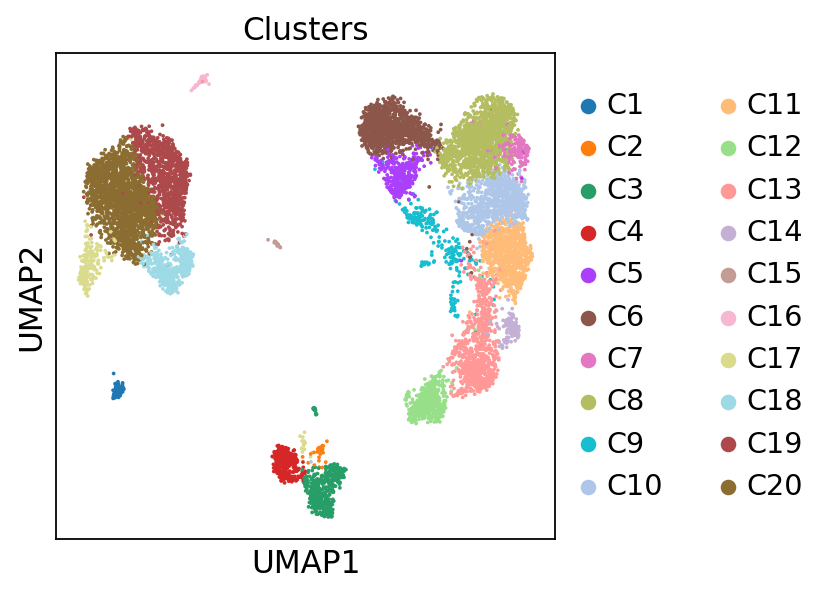

0.0 20.0


/tmp/ipykernel_150388/3307387723.py:257: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_atac_new = ad.AnnData(X_atac)


computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


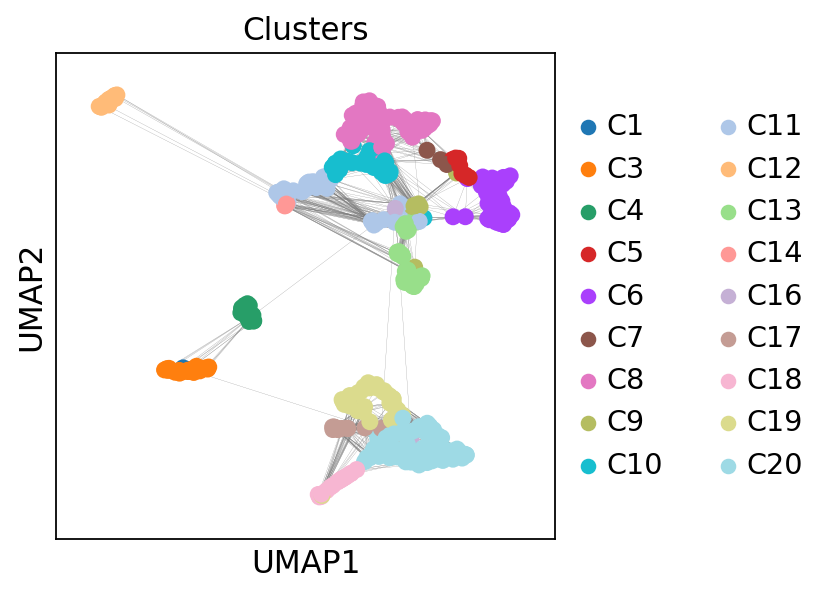

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%


In [ ]:
adata_atac, adata_motif = load_data(load_lsi=if_load_lsi, n_neighbors=n_neighbors)
# poisson correction
if if_poisson_correction:
    adata_atac = poisson_correction(adata_atac)
# normal I
if if_poisson_correction and if_pearson_residuals_first:
    sc.experimental.pp.normalize_pearson_residuals(adata_atac, theta=np.Inf)
elif if_pearson_residuals_first:
    sc.experimental.pp.normalize_pearson_residuals(adata_atac)
# meta-cell
if if_sneha:
    groups, group_clusters, lib_sizes = group_atac_sneha(adata_atac, n_neighbors=n_neighbors, 
                                                         max_allowed_overlap=0.9, N_ITER=20)
else:
    groups, group_clusters, lib_sizes = group_atac_sarah(adata_atac, n_neighbors=n_neighbors, 
                                                         max_allowed_overlap=0.3, N_ITER=1000)
if if_pearson_residuals_first:
    adata_atac_meta = meta_atac(groups, group_clusters, adata_atac, merge_mode='mean')
else:
    adata_atac_meta = meta_atac(groups, group_clusters, adata_atac, merge_mode='sum')
# filter
if if_filter_summits == 'chipseeker':
    adata_atac_filtered = adata_atac_meta[:, adata_atac.var['annotation'].isin(["Promoter (1-2kb)", "Promoter (<=1kb)", "Promoter (2-3kb)", "Distal Intergenic"])]
    adata_motif_filtered = adata_motif[adata_atac.var['annotation'].isin(["Promoter (1-2kb)", "Promoter (<=1kb)", "Promoter (2-3kb)", "Distal Intergenic"]), :]
elif if_filter_summits == 'accessibility':
    tmp = adata_atac_meta.X.copy()
    tmp[tmp>0] = 1
    accessibe_count = np.sum(tmp, axis=0)
    INDEX = np.argsort(accessibe_count)[::-1][:accessibe_count.shape[0]//2]
    adata_atac_filtered = adata_atac_meta[:, INDEX]
    adata_motif_filtered = adata_motif[INDEX, :]
else:
    adata_atac_filtered = adata_atac_meta
    adata_motif_filtered = adata_motif
# normal II
if if_pearson_residuals_first is False and if_pearson_residuals_norm:
    sc.experimental.pp.normalize_pearson_residuals(adata_atac_filtered)
    Y = adata_atac_filtered.X
    X = adata_motif_filtered.X.toarray()
elif if_pearson_residuals_first is False:
    Y = adata_atac_filtered.X / adata_atac_meta.obs['ReadsInTSS'].values[:, np.newaxis]
    X = adata_motif_filtered.X.toarray()
else:
    Y = adata_atac_filtered.X
    X = adata_motif_filtered.X.toarray()

train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 3)
X_train = X[train_ix]
Y_train = Y[:, train_ix]
X_test = X[test_ix]
Y_test = Y[:, test_ix]

w, r, mse = ridge_reg(X_train, Y_train, if_scale=if_scale, if_grid_search=if_grid_search)


In [ ]:
print(X.shape, Y.shape)

In [ ]:
ax = seaborn.displot(r)
plt.axvline(np.median(r), 0, 10000,  linestyle='--', color='r')
# plt.savefig(f'model_selection_{JOB_INDEX}_correlation_hist.png', bbox_inches='tight')
plt.show()

# UMAP of learned TF weights for the meta cells
adata_w = sc.AnnData(w)
# sc.pp.scale(adata_w, max_value=10)
adata_w.obs = adata_atac_meta.obs   
adata_w.obs['rho'] = r
sc.tl.pca(adata_w, svd_solver='arpack', use_highly_variable = False)
sc.pp.neighbors(adata_w, n_neighbors=20, n_pcs=30, metric = "euclidean")
sc.tl.umap(adata_w, min_dist = 0.3)    
sc.tl.leiden(adata_w)


# plot using cluster annotations
sc.pl.umap(adata_w, edges = True, color = ['Clusters'])      

# plot Spearman correlation across the meta cells
g = seaborn.scatterplot(adata_w.obsm['X_umap'][:, 0], adata_w.obsm['X_umap'][:, 1],
                    hue=adata_w.obs['rho'], palette='Spectral_r', edgecolor='none',
                    alpha=0.5, legend='brief')
g.legend_.remove()

norm = plt.Normalize(adata_w.obs['rho'].min(), adata_w.obs['rho'].max())
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
g.figure.colorbar(sm)

# sc.tl.leiden(adata_w)
sc.pl.umap(adata_w, edges = True, color = ['leiden'])      
# plt.savefig('foo.png', bbox_inches='tight')
clustering_scores = homogeneity_completeness_v_measure(adata_w.obs['Clusters'], adata_w.obs['leiden'].values)

print(PARAMS[JOB_INDEX])
print(clustering_scores)

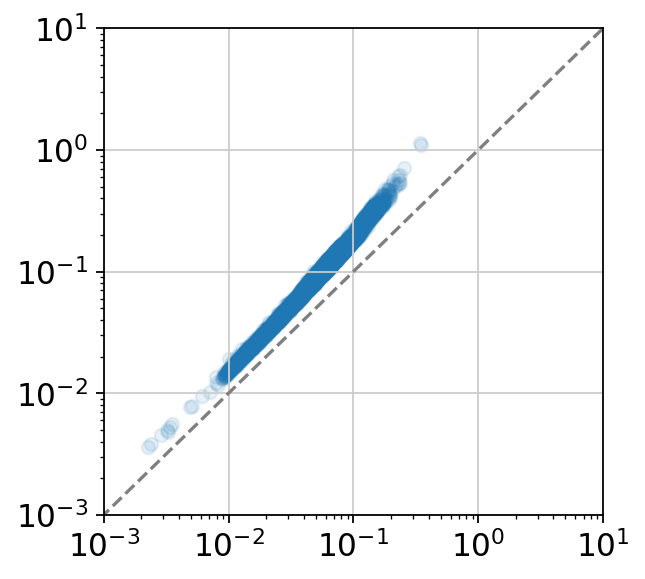

In [26]:
plot_poisson_assumpition(adata_atac.X.toarray())

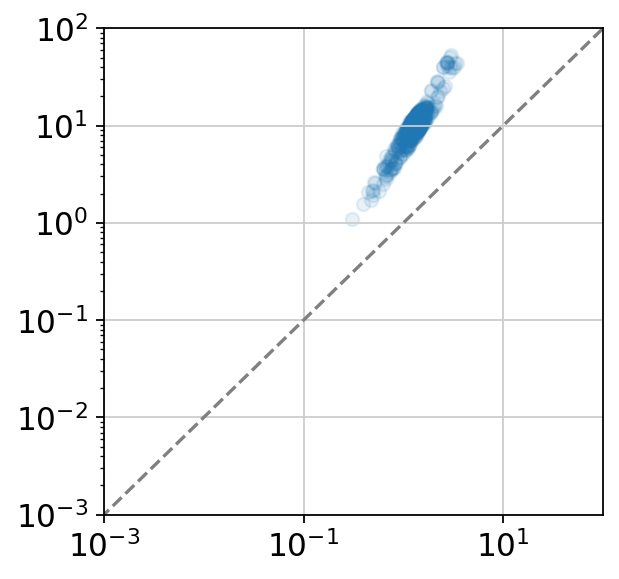

In [16]:
def plot_poisson_assumpition(X):
    c_mean_var = check_poisson_assumption(X)
    plt.scatter(c_mean_var[:, 0], c_mean_var[:, 1], alpha=0.1)
    plt.plot([0, 100], [0, 100], '--', color='gray')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([0.001, 100])
    plt.ylim([0.001, 100])
    
plot_poisson_assumpition(adata_atac_meta.X)

In [ ]:
[25000, 40000, 64000, 100000, 160000, 250000]

In [28]:
def ridge_reg(X, Y):

    # X: peak x TF matrix
    # Y: peak x meta cell (or single cell) matrix
    # W: learned coefficient vectors for separate regression of Y_i = X x W_i

    rhos = {}
    mses = {}

    train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 9)
    scaler = StandardScaler() 
    scaler.fit(X[train_ix])
    x_train = scaler.transform(X[train_ix]).astype(np.float32)
    x_test = scaler.transform(X[test_ix]).astype(np.float32)
    STEP = Y.shape[0]//10    
    tuned_parameters = {'alpha': [1000, 10000, 15000, 20000, 25000, 40000, 64000, 100000]}
    for alpha in tuned_parameters['alpha']:
        print(alpha)
        rhos[alpha] = []
        mses[alpha] = []
        for i in range(Y.shape[0]):
            if i % STEP == 0:
                print(f'{10*i/STEP}%')
            y = Y[i]    
            y_train = y[train_ix]
            y_test = y[test_ix]

            clf = linear_model.Ridge(alpha=alpha)
            clf.fit(x_train, y_train)

            ypred = clf.predict(x_test)
            rho, _ = stats.spearmanr(ypred, y_test) 
            mse = mean_squared_error(y_test, ypred)
            rhos[alpha].append(rho)
            mses[alpha].append(mse)
    return rhos, mses

In [33]:
adata_atac.var['annotation'].value_counts()[:20]

Promoter (<=1kb)                                     69735
Distal Intergenic                                    47748
Promoter (1-2kb)                                     11897
Promoter (2-3kb)                                      8621
3' UTR                                                4305
5' UTR                                                 304
Downstream (<=300bp)                                   270
Intron (ENST00000675058.1/440352, intron 1 of 5)       111
Intron (ENST00000372584.5/59269, intron 1 of 7)         77
Intron (ENST00000524717.6/84441, intron 1 of 4)         75
Intron (ENST00000678134.1/596, intron 2 of 2)           67
Intron (ENST00000637419.1/23199, intron 2 of 2)         64
Intron (ENST00000437180.5/861, intron 2 of 8)           63
Intron (ENST00000486895.5/10301, intron 1 of 1)         63
Intron (ENST00000345617.7/9759, intron 2 of 26)         57
Intron (ENST00000509479.6/55534, intron 1 of 4)         56
Intron (ENST00000649528.3/27086, intron 3 of 20)        

In [29]:
rhos, mses = ridge_reg(X_train, Y_train)

1000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
10000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
15000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
20000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
25000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
40000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
64000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100000
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


In [30]:
import joblib
alpha = [1000, 10000, 15000, 20000, 25000, 40000, 64000, 100000]
joblib.dump([alpha, rhos, mses], 'results/motif_regression_output/RESULTS_parameter_sweep_zoomed.joblib')

['results/motif_regression_output/RESULTS_parameter_sweep_zoomed.joblib']

1000 0.41539571844013434 1.5302506177580698e-10
10000 0.41957361715838315 1.5297208277383508e-10
15000 0.42146278415454486 1.5314876733908734e-10
20000 0.4231298449140898 1.534078735287266e-10
25000 0.42453571901997367 1.5372338025656808e-10
40000 0.42794411627285245 1.54869533364494e-10
64000 0.43125401477453384 1.5685035688034812e-10
100000 0.4333187536621895 1.5984655562340072e-10


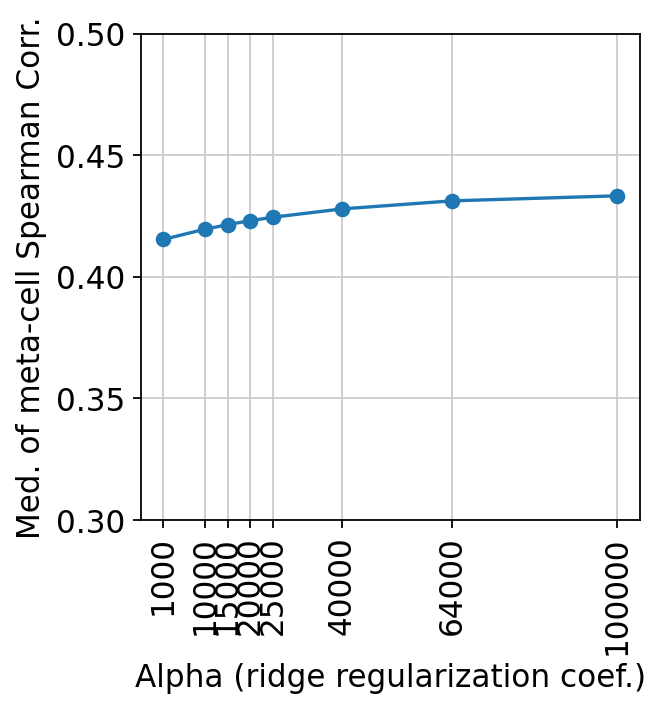

In [31]:
rho_mat = np.zeros((len(alpha), len(rhos[alpha[0]])))
mses_mat = np.zeros((len(alpha), len(rhos[alpha[0]])))
for a_idx, a in enumerate(alpha):
    for c_idx, val in enumerate(rhos[a]):
        rho_mat[a_idx, c_idx] = val
        mses_mat[a_idx, c_idx] = mses[a][c_idx]
res = []
for i in range(len(alpha)):
    print(alpha[i], np.median(rho_mat[i]), np.median(mses_mat[i]))
    res.append((alpha[i], np.median(rho_mat[i])))
plt.plot([i[0] for i in res], [i[1] for i in res], '-o')
# plt.xscale('log')
plt.xticks([i[0] for i in res], rotation=90)
plt.ylim([0.3, .5])
plt.ylabel('Med. of meta-cell Spearman Corr.')
plt.xlabel('Alpha (ridge regularization coef.)')
plt.show()

In [39]:
# import joblib
# alpha = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
# joblib.dump([alpha, rhos, mses], 'results/motif_regression_output/RESULTS_parameter_sweep.joblib')

['results/motif_regression_output/RESULTS_parameter_sweep.joblib']

In [40]:
len(rhos[0.01])

550

In [41]:
rho_mat = np.zeros((len(alpha), len(rhos[alpha[0]])))
mses_mat = np.zeros((len(alpha), len(rhos[alpha[0]])))
for a_idx, a in enumerate(alpha):
    for c_idx, val in enumerate(rhos[a]):
        rho_mat[a_idx, c_idx] = val
        mses_mat[a_idx, c_idx] = mses[a][c_idx]

In [54]:
res = []
for i in range(len(alpha)):
    print(alpha[i], np.median(rho_mat[i]), np.median(mses_mat[i]))
    res.append((alpha[i], np.median(rho_mat[i])))

0.01 0.41480017718984363 1.5307241492284879e-10
0.1 0.41480016720408425 1.5307241051916756e-10
1 0.41480072694800885 1.5307236306562863e-10
10 0.41480642791488687 1.530718898719558e-10
100 0.4148617378244209 1.5306721428708676e-10
1000 0.41539571844013434 1.5302506177580698e-10
10000 0.41957361715838315 1.5297208277383508e-10
100000 0.4333187536621895 1.5984655562340072e-10
1000000 0.4196414367685131 1.865214865429344e-10
10000000 0.406145010201031 2.0606043785657135e-10


In [57]:
[i[0] for i in res]

[0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

In [58]:
 [i[1] for i in res]

[0.41480017718984363,
 0.41480016720408425,
 0.41480072694800885,
 0.41480642791488687,
 0.4148617378244209,
 0.41539571844013434,
 0.41957361715838315,
 0.4333187536621895,
 0.4196414367685131,
 0.406145010201031]

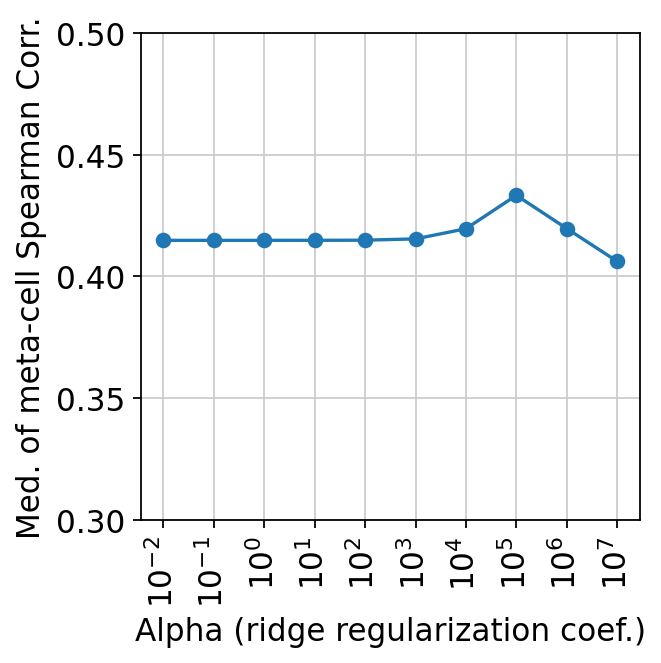

In [80]:
plt.plot([i[0] for i in res], [i[1] for i in res], '-o')
plt.xscale('log')
plt.xticks([i[0] for i in res], rotation=90)
plt.ylim([0.3, .5])
plt.ylabel('Med. of meta-cell Spearman Corr.')
plt.xlabel('Alpha (ridge regularization coef.)')
plt.show()

In [93]:
alpha = [25000, 40000, 64000, 100000, 160000, 250000]

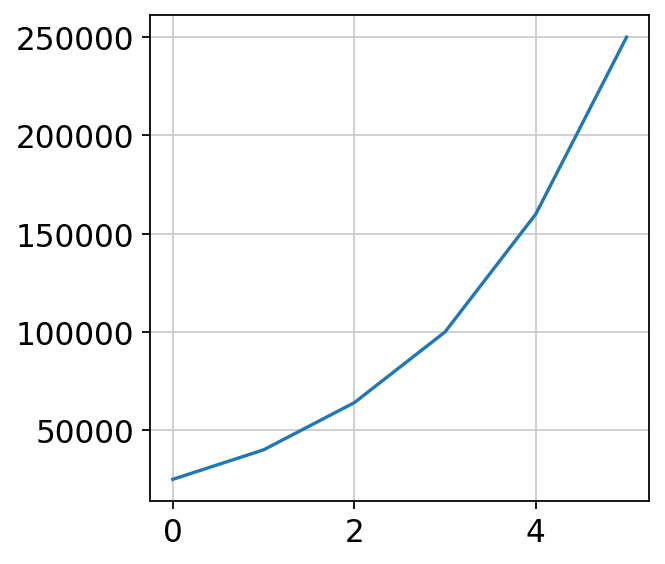

In [96]:
plt.plot(alpha)
# plt.yscale('log')
plt.show()

In [92]:
np.round(np.power(10, np.arange(4.4, 5.6, 0.2)))

array([ 25119.,  39811.,  63096., 100000., 158489., 251189.])

In [ ]:
w, r, mse = ridge_reg(X_train, Y_train, if_scale=if_scale, if_grid_search=if_grid_search)
ax = seaborn.displot(r)
plt.axvline(np.median(r), 0, 10000,  linestyle='--', color='r')

In [8]:
def reg_one_metacell(X, Y, cell_id=0):
    train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 9)
    scaler = StandardScaler() 
    scaler.fit(X[train_ix])
    x_train = scaler.transform(X[train_ix]).astype(np.float32)
    x_test = scaler.transform(X[test_ix]).astype(np.float32)
    tuned_parameters = {'alpha': [25000, 40000, 64000, 100000, 160000, 250000]}
    y = Y[cell_id]    
    y_train = y[train_ix]
    y_test = y[test_ix]
        
    clf = GridSearchCV(linear_model.Ridge(), tuned_parameters, cv=5, n_jobs=4, scoring="r2")
       
    clf.fit(x_train, y_train)

    return clf, x_train, y_train, x_test, y_test

In [9]:
clf, x_train, y_train, x_test, y_test = reg_one_metacell(X_train, Y_train, cell_id=0)

In [11]:
clf.best_score_

0.16135878275232976

In [25]:
ypred = clf.predict(x_test)
rho, _ = stats.spearmanr(ypred, y_test) 
mse = mean_squared_error(y_test, ypred*4)

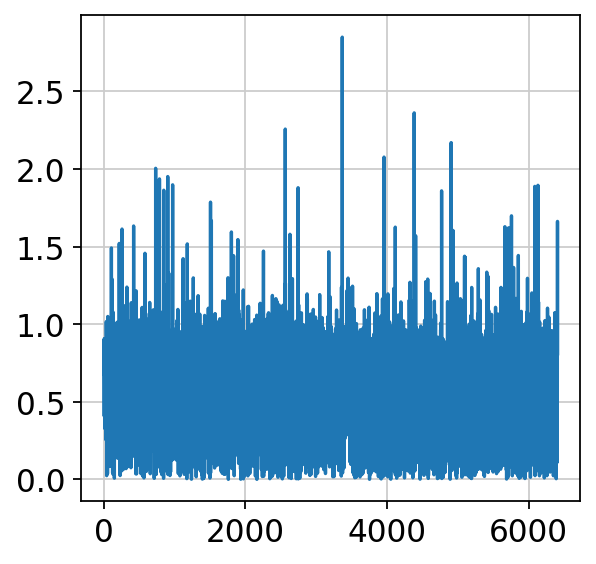

In [36]:
plt.plot(np.abs(ypred[y_test!=0]-y_test[y_test!=0])/y_test[y_test!=0])
plt.show()

In [39]:
sb = np.abs(ypred[y_test!=0]-y_test[y_test!=0])/y_test[y_test!=0]

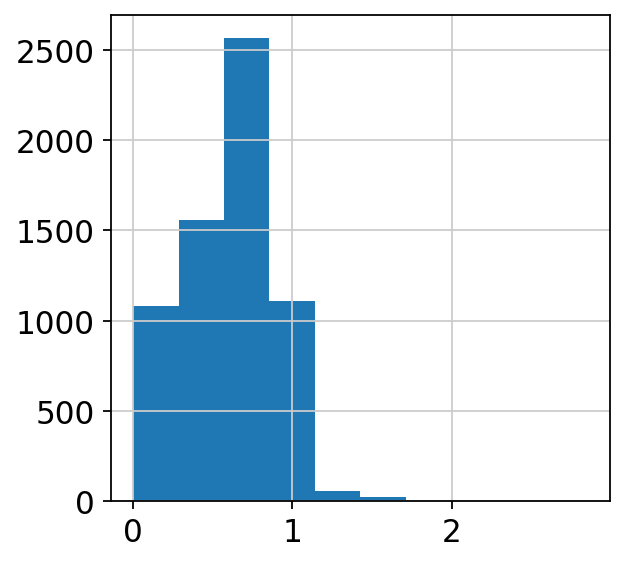

In [43]:
plt.hist(sb.toarray())
plt.show()

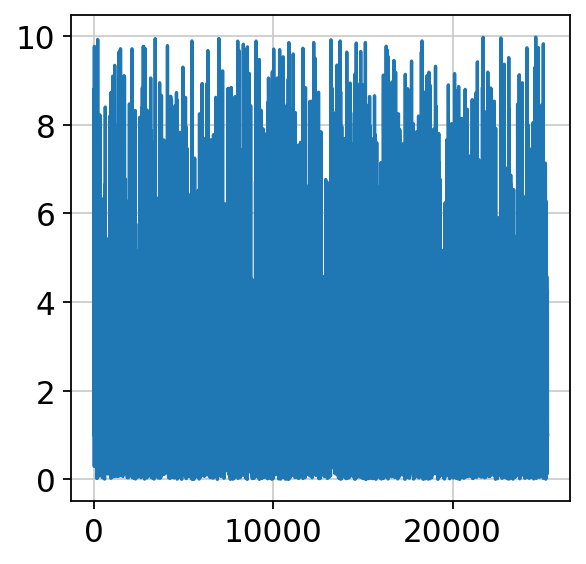

In [52]:
sb = np.abs(ypred-y_test)/np.abs(ypred)
sb = sb[sb<10]
plt.plot(sb)
plt.show()

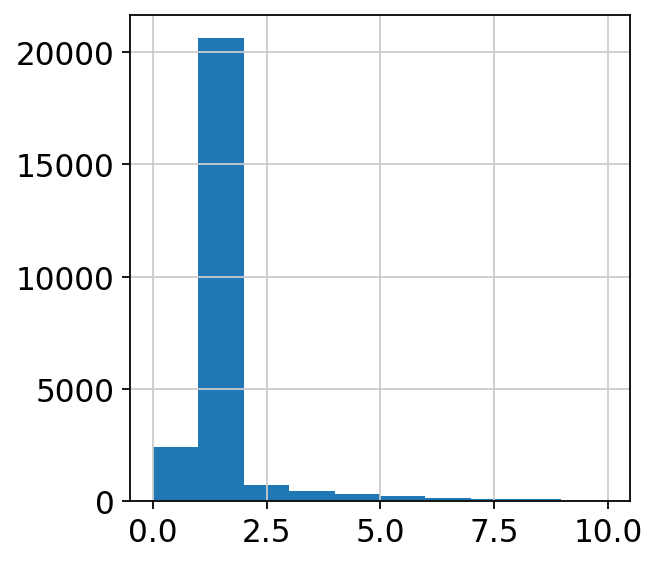

In [53]:
plt.hist(sb.toarray())
plt.show()

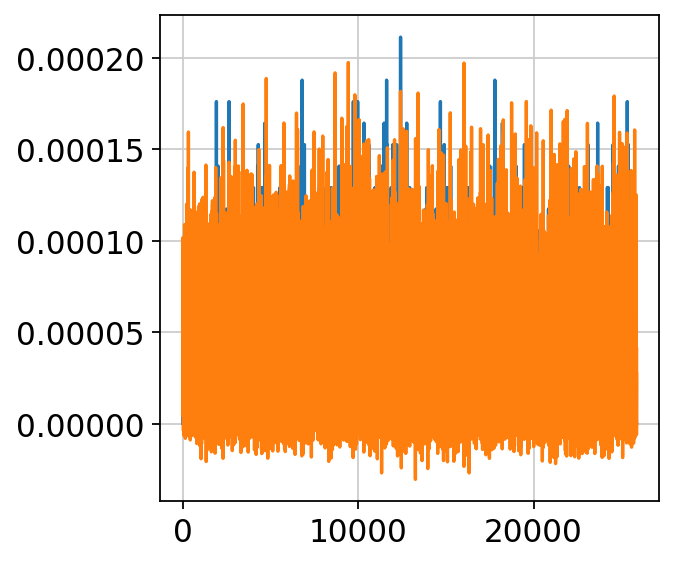

In [29]:
plt.plot(y_test)
plt.plot(ypred*4)
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
def logistic_reg_one_metacell(X, Y, cell_id=0):
    train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 9)
    scaler = StandardScaler() 
    scaler.fit(X[train_ix])
    x_train = scaler.transform(X[train_ix]).astype(np.float32)
    x_test = scaler.transform(X[test_ix]).astype(np.float32)

    y = Y[cell_id].copy()
    y[y>0] = 1
    y_train = y[train_ix]
    y_test = y[test_ix]
    
#     clf = LogisticRegression(penalty='l2', random_state=0, class_weight='balanced')
    clf = LogisticRegression(penalty='l2', random_state=0)
       
    clf.fit(x_train, y_train)

    return clf, x_train, y_train, x_test, y_test

In [10]:
from sklearn.metrics import balanced_accuracy_score

res = []
for i in range(Y_train.shape[0]):
    if i % 50 == 0:
        print(i)
    clf, x_train, y_train, x_test, y_test = logistic_reg_one_metacell(X_train, Y_train, cell_id=i)
    ypred = clf.predict(x_test)
    
    res.append(balanced_accuracy_score(y_test, ypred))

0


KeyboardInterrupt: 

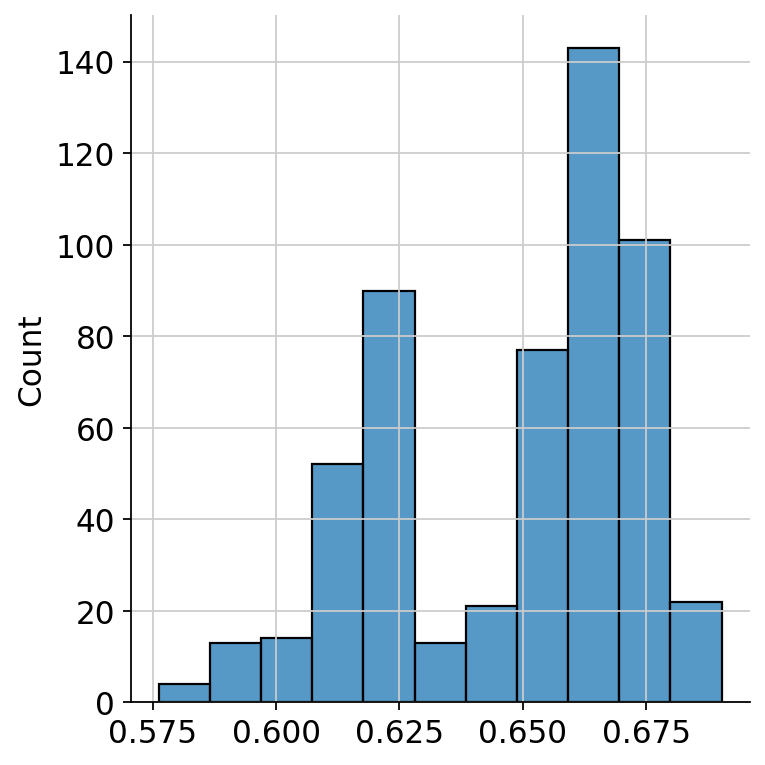

In [76]:
ax = seaborn.displot(res)

In [77]:
np.median(res)

0.6581229442890566

In [70]:
ypred = clf.predict(x_test)

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, ypred)


array([[7693, 4667],
       [4730, 8785]])

In [72]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, ypred)

0.636214750600735

In [74]:
Y_train.shape

(550, 103500)

In [34]:
print(['n', 'lsi', 'poi', 'pear', 'meta_sn', 'filter', 'pear', 'scale_X', 'grid'])

['n', 'lsi', 'poi', 'pear', 'meta_sn', 'filter', 'pear', 'scale_X', 'grid']


In [33]:
!tail slurm-39060580_*

==> slurm-39060580_1.out <==
0.18722357453423685
{'alpha': 25000}
0.16921141915444507
(550, 693)
0.2968-(0.4245)-0.4912
[20, True, False, False, True, 'chipseeker', False, True, True]
0.7814 & 0.8401 & 0.8097
['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C2'
 'C20' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9']
['0' '1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9']

==> slurm-39060580_2.out <==
0.25164109850389477
{'alpha': 25000}
0.25125233838903704
(515, 693)
0.3560-(0.4715)-0.5066
[90, True, False, False, True, 'chipseeker', False, True, True]
0.8215 & 0.8314 & 0.8264
['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C16' 'C17' 'C18' 'C19' 'C20' 'C3'
 'C4' 'C5' 'C6' 'C7' 'C8' 'C9']
['0' '1' '10' '11' '12' '13' '2' '3' '4' '5' '6' '7' '8' '9']

==> slurm-39060580_3.out <==
0.1713582170297477
{'alpha': 25000}
0.15479105487257164
(550, 693)
0.2555-(0.3775)-0.4375
[20, True, False, False, True, 'no filter', False, True, True]
0.8031 & 0.8942 & 0.8462
['C1' 'C10' 'C11' 'C12' 'C13' 'C14' '

In [32]:
!squeue -u zz5084

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [ ]:
from sklearn.metrics import make_scorer
def ridge_reg(X, Y, if_scale=True, if_grid_search=True):

    # X: peak x TF matrix
    # Y: peak x meta cell (or single cell) matrix
    # W: learned coefficient vectors for separate regression of Y_i = X x W_i
    
    

    spearmanr = make_scorer(
        'spearmanr',
        lambda x, y: stats.spearmanr(x, y)[0]
    )

    rhos = []
    mses = []
    W = []

    train_ix, test_ix = train_test_split(np.arange(Y.shape[1]), random_state = 9)
    tuned_parameters = {'alpha': [25000, 40000, 64000, 100000, 160000, 250000]}
    
    if if_scale:
        scaler = StandardScaler() 
        scaler.fit(X[train_ix])
        x_train = scaler.transform(X[train_ix]).astype(np.float32)
        x_test = scaler.transform(X[test_ix]).astype(np.float32)
    else:
        x_train = X[train_ix]
        x_test = X[test_ix]

    STEP = Y.shape[0]//10
    for i in range(Y.shape[0][:10]):
        if i % STEP == 0:
            print(f'{10*i/STEP}%')
        y = Y[i]    
        y_train = y[train_ix]
        y_test = y[test_ix]
        if if_grid_search:
            clf = GridSearchCV(linear_model.Ridge(), tuned_parameters, cv=5, n_jobs=4, scoring=spearmanr)
        else:
            clf = linear_model.Ridge(alpha=1000000)
        clf.fit(x_train, y_train)
        
        if if_grid_search:
            w = clf.best_estimator_.coef_
        else:
            w = clf.coef_
        W.append(list(w))
        ypred = clf.predict(x_test)
        rho, _ = stats.spearmanr(ypred, y_test) 
        mse = mean_squared_error(y_test, ypred)
        rhos.append(rho)
        mses.append(mse)
    return np.array(W), np.array(rhos), np.array(mses)

In [ ]:
rhos, mses = ridge_reg(X_train, Y_train)